# Manuscript7 - Compute percent of significant information transfers FROM source regions

## Analysis for Fig. 7


## Master code for Ito et al., 2017¶
#### Takuya Ito (takuya.ito@rutgers.edu)


In [24]:
import sys
sys.path.append('utils/')
import numpy as np
import loadGlasser as lg
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.sandbox.stats.multicomp as mc
import sys
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import nibabel as nib
import os
import permutationTesting as pt

from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm



class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
class MidpointNormalizeLog(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
class MidpointNormalize2(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        t1 = (self.midpoint - self.vmin)/2.0
        t2 = (self.vmax - self.midpoint)/30.0 + self.midpoint
        x, y = [self.vmin, t1, self.midpoint, t2, self.vmax], [0, 0.25, .5, .75, 1.0]
        return np.ma.masked_array(np.interp(value, x, y))

# 0.0 Basic parameters

In [25]:
# Set basic parameters
basedir = '/projects2/ModalityControl2/'
datadir = basedir + 'data/'
resultsdir = datadir + 'resultsMaster/'
runLength = 4648

subjNums = ['032', '033', '037', '038', '039', '045', 
            '013', '014', '016', '017', '018', '021', 
            '023', '024', '025', '026', '027', '031', 
            '035', '046', '042', '028', '048', '053', 
            '040', '049', '057', '062', '050', '030', '047', '034']

glasserparcels = lg.loadGlasserParcels()
networkdef = lg.loadGlasserNetworks()

# Define the main networks (in main manuscript)
networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud':8, 'aud2':9, 'dan':11}
# Force aud2 key to be the same as aud1
# aud2_ind = np.where(networkdef==networkmappings['aud2'])[0]
# networkdef[aud2_ind] = networkmappings['aud1']
# Merge aud1 and aud2
# networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud':8, 'dan':11}

nParcels = 360

# Import network reordering
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
order = networkorder
order.shape = (len(networkorder),1)

# Construct xticklabels and xticks for plotting figures
networks = networkmappings.keys()
xticks = {}
reorderednetworkaffil = networkdef[order]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net
    
# Load in Glasser parcels in their native format (vertex formula)
glasserfilename = '/projects/AnalysisTools/ParcelsGlasser2016/archive/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii'
glasser2 = nib.load('/projects/AnalysisTools/ParcelsGlasser2016/archive/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii')
glasser2 = np.squeeze(glasser2.get_data())

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


# 1.0 Run Region-to-region information transfer mapping

##### Due to computational constraints, all region-to-region activity flow mapping procedures and the RSA analyses were run on the supercomputer using  MATLAB scripts in ./SupercomputerScripts/Fig6_RegionToRegionInformationTransferMapping/


# 2.0 Construct information transfer mapping matrix

In [26]:
## Load in NM3 Data
ruledims = ['logic','sensory','motor']
datadir = '/projects2/ModalityControl2/data/resultsMaster/Manuscript6andS2and7_RegionToRegionITE/'
# Load in RSA matrices
rsaMats = {}
df_stats = {}
for ruledim in ruledims:
    rsaMats[ruledim] = np.zeros((nParcels,nParcels,len(subjNums)))
    df_stats[ruledim] = {}
    scount = 0
    for subj in subjNums:
        filename = datadir +subj+'_' + ruledim + '_RegionToRegionActFlowGlasserParcels.csv'
        rsaMats[ruledim][:,:,scount] = np.loadtxt(filename, delimiter=',')
        scount += 1



In [27]:
## Compute Group Stats
for ruledim in ruledims:
    ## Compute group statistics
    # Compute average across subjects
    df_stats[ruledim]['avgrho'] = np.mean(rsaMats[ruledim],axis=2)
    # Compute t-test for each pairwise connection
    t = np.zeros((nParcels,nParcels))
    p = np.zeros((nParcels,nParcels))
    for i in range(nParcels):
        for j in range(nParcels):
            t[i,j], p[i,j] = stats.ttest_1samp(rsaMats[ruledim][i,j,:], 0)
            # One-sided t-test so...
            if t[i,j] > 0:
                p[i,j] = p[i,j]/2.0
            else:
                p[i,j] = 1.0-(p[i,j]/2.0)
    
    df_stats[ruledim]['t'] = t
    df_stats[ruledim]['p'] = p
    
    ## Run multiple corrections
    triu_ind = np.triu_indices(nParcels,k=1)
    tril_ind = np.tril_indices(nParcels,k=-1)
    tmpq = []
    tmpq.extend(df_stats[ruledim]['p'][triu_ind])
    tmpq.extend(df_stats[ruledim]['p'][tril_ind])
    # only run FDR correction on non-NaN values
    ind_nans = np.isnan(tmpq)
    ind_nonnan = np.where(ind_nans==False)[0]
    tmpq = np.asarray(tmpq)
    tmpq2 = mc.fdrcorrection0(tmpq[ind_nonnan])[1]
    tmpq[ind_nonnan] = tmpq2
    qmat = np.zeros((nParcels,nParcels))
    qmat[triu_ind] = tmpq[0:len(triu_ind[0])]
    qmat[tril_ind] = tmpq[len(tril_ind[0]):]
    
    df_stats[ruledim]['q'] = qmat
    np.fill_diagonal(df_stats[ruledim]['q'],1)
    


## 2.1 Visualize Information transfer mapping matrices (Threshold and Unthresholded)

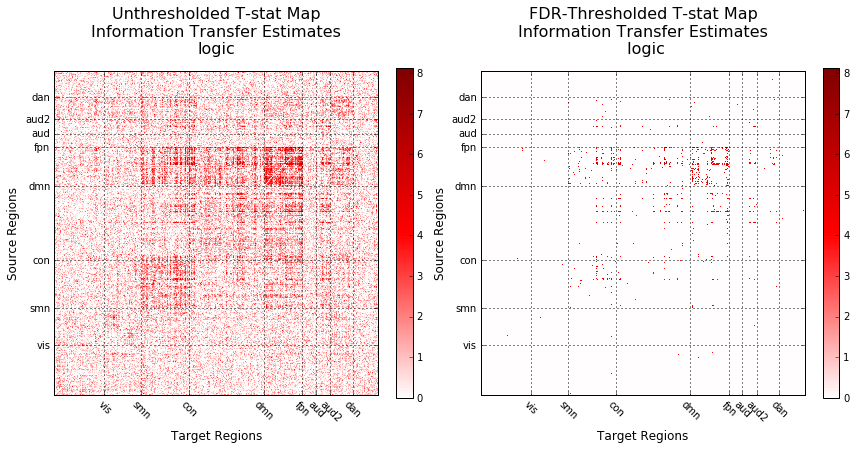

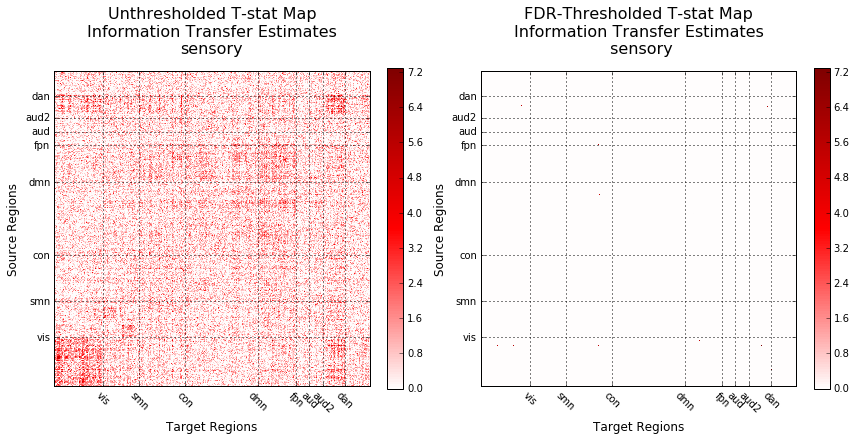

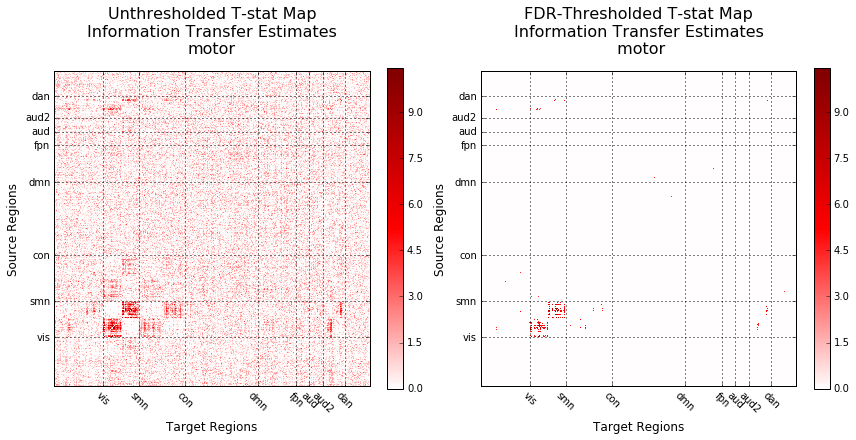

In [28]:
# Visualize Unthresholded and thresholded side-by-side
order = networkorder
order.shape = (len(networkorder),1)
for ruledim in ruledims:

    # Unthresholded t-stat map
    plt.figure(figsize=(12,10))
    plt.subplot(121)
    # First visualize unthresholded
    mat = df_stats[ruledim]['t'][order,order.T]
    ind = np.isnan(mat)
    mat[ind] = 0
    pos = mat > 0
    mat = np.multiply(pos,mat)
    norm = MidpointNormalize(midpoint=0)
    plt.imshow(mat,origin='lower',vmin=0, norm=norm, interpolation='none',cmap='seismic')
    plt.colorbar(fraction=0.046)
    plt.title('Unthresholded T-stat Map\nInformation Transfer Estimates\n' + ruledim,
              fontsize=16,y=1.04)
    plt.xlabel('Target Regions',fontsize=12)
    plt.ylabel('Source Regions', fontsize=12)
    plt.xticks(xticks.keys(),xticks.values(), rotation=-45)
    plt.yticks(xticks.keys(),xticks.values())
    plt.grid(linewidth=1)
#     plt.tight_layout()

    
    # Thresholded T-stat map
    plt.subplot(122)
    # First visualize unthresholded
    mat = df_stats[ruledim]['t']
    thresh = df_stats[ruledim]['q'] < 0.05
    mat = np.multiply(mat,thresh)
    mat = mat[order,order.T]
    ind = np.isnan(mat)
    mat[ind]=0
    pos = mat > 0
    mat = np.multiply(pos,mat)
    norm = MidpointNormalize(midpoint=0)
    plt.imshow(mat,origin='lower',norm=norm,vmin = 0,interpolation='none',cmap='seismic')
    plt.colorbar(fraction=0.046)
    plt.title('FDR-Thresholded T-stat Map\nInformation Transfer Estimates\n ' + ruledim,
              fontsize=16, y=1.04)
    plt.xlabel('Target Regions',fontsize=12)
    plt.ylabel('Source Regions', fontsize=12)
    plt.xticks(xticks.keys(),xticks.values(), rotation=-45)
    plt.yticks(xticks.keys(),xticks.values())
    plt.grid(linewidth=1)
    plt.tight_layout()

#     plt.savefig('Fig4b_Connectome_ActFlowRSA_TstatMap_MatchVMismatch_' + ruledim + '.pdf')

## 2.2 Compute the regions with the most information transfers TO and FROM

In [29]:
networks = networkmappings.keys()

regions_actflowTO = {}
regions_actflowFROM = {}

for ruledim in ruledims:
          
    thresh = df_stats[ruledim]['q'] < 0.05
    regions_actflowFROM[ruledim] = np.nanmean(thresh,axis=1)*100.0
    regions_actflowTO[ruledim] = np.nanmean(thresh,axis=0)*100.0

#     # Convert to dataframe
#     plt.figure() 
#     plt.bar(np.arange(nParcels),regions_actflow[ruledim],align='center')
#     plt.title('Percent of Significant ActFlow FROM each region', fontsize=16)
#     plt.ylabel('Percent of Significant ActFlow\nTo Other Regions', fontsize=12)
#     plt.xlabel('Regions', fontsize=12)
#     plt.tight_layout()
    


In [30]:
# Save these arrays to a file
savearrayTO = np.zeros((len(glasser2),len(ruledims)+1))
savearrayFROM = np.zeros((len(glasser2),len(ruledims)+1))

rulecount = 0
for ruledim in ruledims:
    for roi in range(1,nParcels+1):
        parcel_ind = np.where(glasser2==roi)[0]
        # Compute map of all rule dimension for rule general actflow
        if rulecount < 3:
            savearrayTO[parcel_ind,rulecount] = regions_actflowTO[ruledim][roi-1].astype('double')
            savearrayFROM[parcel_ind,rulecount] = regions_actflowFROM[ruledim][roi-1].astype('double')

    rulecount += 1

to_avg = savearrayTO[:,0:3] > 0
# Create conjunction map
to_avg = np.mean(to_avg,axis=1)
to_avg = (to_avg == 1)
savearrayTO[:,3] = to_avg

from_avg = savearrayFROM[:,0:3] > 0
from_avg = np.mean(from_avg,axis=1)
from_avg = (from_avg == 1)
savearrayFROM[:,3] = from_avg

outdir = '/projects2/ModalityControl2/data/resultsMaster/Manuscript6andS2and7_RegionToRegionITE/'
filename = 'PercentOfRegionsSignificantActFlowFROM_FDR.csv'
np.savetxt(outdir + filename,savearrayFROM,fmt='%s')
wb_file = 'PercentOfRegionsSignificantActFlowFROM_FDR.dscalar.nii'
wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + ' ' + glasserfilename + ' ' + outdir + wb_file + ' -reset-scalars'
os.system(wb_command)

outdir = '/projects2/ModalityControl2/data/resultsMaster/Manuscript6andS2and7_RegionToRegionITE/'
filename = 'PercentOfRegionsSignificantActFlowTO_FDR.csv'
np.savetxt(outdir + filename,savearrayTO,fmt='%s')
wb_file = 'PercentOfRegionsSignificantActFlowTO_FDR.dscalar.nii'
wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + ' ' + glasserfilename + ' ' + outdir + wb_file + ' -reset-scalars'
os.system(wb_command)

0

# 3.0 Compute FWE-corrected results (as opposed to FDR)

In [31]:
## Load in NM3 Data
ruledims = ['logic','sensory','motor']
datadir = '/projects2/ModalityControl2/data/resultsMaster/Manuscript6andS2and7_RegionToRegionITE/'
# Load in RSA matrices
iteMats = {}
df_stats = {}
for ruledim in ruledims:
    iteMats[ruledim] = np.zeros((nParcels,nParcels,len(subjNums)))
    df_stats[ruledim] = {}
    scount = 0
    for subj in subjNums:
        filename = datadir +subj+'_' + ruledim + '_RegionToRegionActFlowGlasserParcels.csv'
        iteMats[ruledim][:,:,scount] = np.loadtxt(filename, delimiter=',')
        scount += 1



In [32]:
pt = reload(pt)

fwe_Ts = np.zeros((nParcels,nParcels,len(ruledims)))
fwe_Ps = np.zeros((nParcels,nParcels,len(ruledims)))

# Obtain indices for multiple comparisons
indices = np.ones((nParcels,nParcels))
np.fill_diagonal(indices,0)
notnan_ind = np.isnan(iteMats['logic'][:,:,0])==False
indices = np.multiply(indices,notnan_ind)
flatten_ind = np.where(indices==1)
rulecount = 0



for ruledim in ruledims:
#     tmpcor = np.arctanh(corrMats[ruledim][flatten_ind[0],flatten_ind[1],:])
#     tmperr = np.arctanh(errMats[ruledim][flatten_ind[0],flatten_ind[1],:])
    t, p = pt.permutationFWE(iteMats[ruledim][flatten_ind[0],flatten_ind[1],:], permutations=1000, nproc=15)
    fwe_Ts[flatten_ind[0],flatten_ind[1],rulecount] = t
    fwe_Ps[flatten_ind[0],flatten_ind[1],rulecount] = 1.0 - p
    
    rulecount += 1

## 3.1 Visualize information transfer mapping matrices (FWE-Threshold and Unthresholded)

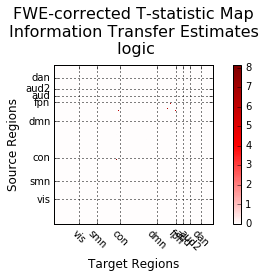

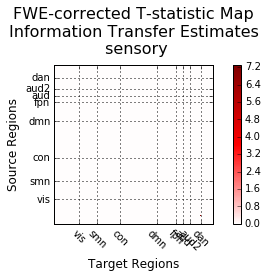

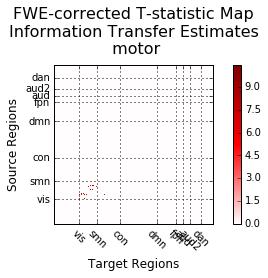

In [33]:
pthresh = .05

# Visualize FWER-corrected T-statistic map
order = networkorder
order.shape = (len(networkorder),1)
rulecount = 0
for ruledim in ruledims:
    
    # Thresholded T-stat map
    plt.figure()
    # First visualize unthresholded
    mat = fwe_Ts[:,:,rulecount]
    thresh = fwe_Ps[:,:,rulecount] < pthresh
    mat = np.multiply(mat,thresh)
    mat = mat[order,order.T]
    ind = np.isnan(mat)
    mat[ind]=0
    pos = mat > 0
    mat = np.multiply(pos,mat)
    norm = MidpointNormalize(midpoint=0)
    plt.imshow(mat,origin='lower',norm=norm,vmin = 0,interpolation='none',cmap='seismic')
    plt.colorbar(fraction=0.046)
    plt.title('FWE-corrected T-statistic Map\nInformation Transfer Estimates\n ' + ruledim,
              fontsize=16, y=1.04)
    plt.xlabel('Target Regions',fontsize=12)
    plt.ylabel('Source Regions', fontsize=12)
    plt.xticks(xticks.keys(),xticks.values(), rotation=-45)
    plt.yticks(xticks.keys(),xticks.values())
    plt.grid(linewidth=1)
    plt.tight_layout()

#     plt.savefig('Fig6_RegionITE_TstatMap' + ruledim + '_FWER.pdf')

    rulecount += 1


## 3.2 Compute the regions with the most information transfers TO and FROM

In [34]:
networks = networkmappings.keys()

regions_actflowTO = {}
regions_actflowFROM = {}

rulecount = 0
for ruledim in ruledims:
          
    thresh = fwe_Ps[:,:,rulecount] > pthresh
    regions_actflowFROM[ruledim] = np.nanmean(thresh,axis=1)*100.0  
    regions_actflowTO[ruledim] = np.nanmean(thresh,axis=0)*100.0
    rulecount += 1



In [35]:
# Save these arrays to a file
savearrayTO = np.zeros((len(glasser2),len(ruledims)+1))
savearrayFROM = np.zeros((len(glasser2),len(ruledims)+1))

rulecount = 0
for ruledim in ruledims:
    for roi in range(1,nParcels+1):
        parcel_ind = np.where(glasser2==roi)[0]
        # Compute map of all rule dimension for rule general actflow
        if rulecount < 3:
            savearrayTO[parcel_ind,rulecount] = regions_actflowTO[ruledim][roi-1].astype('double')
            savearrayFROM[parcel_ind,rulecount] = regions_actflowFROM[ruledim][roi-1].astype('double')

    rulecount += 1

to_avg = savearrayTO[:,0:3] > 0
# Create conjunction map
to_avg = np.mean(to_avg,axis=1)
to_avg = (to_avg == 1)
savearrayTO[:,3] = to_avg

from_avg = savearrayFROM[:,0:3] > 0
from_avg = np.mean(from_avg,axis=1)
from_avg = (from_avg == 1)
savearrayFROM[:,3] = from_avg

outdir = '/projects2/ModalityControl2/data/resultsMaster/Manuscript6andS2and7_RegionToRegionITE/'
filename = 'PercentOfRegionsSignificantActFlowFROM_FWER.csv'
np.savetxt(outdir + filename,savearrayFROM,fmt='%s')
wb_file = 'PercentOfRegionsSignificantActFlowFROM_FWER.dscalar.nii'
wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + ' ' + glasserfilename + ' ' + outdir + wb_file + ' -reset-scalars'
os.system(wb_command)

outdir = '/projects2/ModalityControl2/data/resultsMaster/Manuscript6andS2and7_RegionToRegionITE/'
filename = 'PercentOfRegionsSignificantActFlowTO_FWER.csv'
np.savetxt(outdir + filename,savearrayTO,fmt='%s')
wb_file = 'PercentOfRegionsSignificantActFlowTO_FWER.dscalar.nii'
wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + ' ' + glasserfilename + ' ' + outdir + wb_file + ' -reset-scalars'
os.system(wb_command)

0